# Libraries

In [55]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from numpy import *
from numpy.fft import *
import mne
# from mne.channels import read_layout
import scipy.signal as signal
from matplotlib.pyplot import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn

# Functions

In [56]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

# Loading Data

In [57]:
p2_all = loadmat('MATLAB/P2/P2_AllLifts.mat')
print( "All Lifts loaded")



#these are the series we are looking at for subject 2. Everything except series 1 and 6
trials_included=[2, 3, 4, 5, 7, 8, 9] 
#trials_included=[2]
#corresponding row indices in P.AllLifts where each series starts. Index is off by one bc of how python indexes things
trialStartIdx = [28, 62, 96, 130, 192, 226, 260]

#data structure to hold all EEG trials 
eeg_grasp_closed = []
eeg_grasp_open = []
emg_grasp_closed = []
emg_grasp_open = []
series_counter = 0
trial_counter = 1
i = 0
for s in trials_included:
    # load all the series specified in trials_included
    series_filename = 'MATLAB/P2/WS_P2_S{series}.mat'.format(series = s)
    p_series = loadmat(series_filename)
    print("Series data loaded")
    series_counter = series_counter + 1
    print("series_counter: ", series_counter)

    #identifying the starting row index in p.ALLLifts for the first trial of the current series
    tStart = trialStartIdx[i]
    i += 1
    trial_counter = 1
    #range for the for loop is 34 values bc there are 34 trials in each series
    for trial_num in range(tStart, tStart + 34):
        
        #retrieving the point in time when both fingers touched object
        #index values are one cloumn and one row before target value
        tBothDigitTouch = np.array(p2_all['P']['AllLifts'])[trial_num, 14]
        
        tBothReleased = np.array(p2_all['P']['AllLifts'])[trial_num, 22]
        
        #converting time points to row indices to be accessed in windowed struct
        #500 samples every second, so timepoint should be divided by 0.002
        idxCloseEnd = int(tBothDigitTouch // 0.002) + int(0.85//0.002)
        idxCloseStart = int(tBothDigitTouch // 0.002)- int(0.85//0.002)
        
        idxOpenEnd = int(tBothReleased // 0.002)+ int(0.85//0.002)
        idxOpenStart = int(tBothReleased // 0.002)- int(0.85//0.002)
        
        idxCloseEndEMG = int(tBothDigitTouch // 0.0002) + int(0.85//0.0002)
        idxCloseStartEMG = int(tBothDigitTouch // 0.0002) - int(0.85//0.0002)
        
        idxOpenEndEMG = int(tBothReleased // 0.0002) + int(0.85//0.0002)
        idxOpenStartEMG = int(tBothReleased // 0.0002) - int(0.85//0.0002)

        eeg_trial = np.array(p_series['ws']['win'][0]['eeg'])[idxCloseStart:idxCloseEnd].T 
        eeg_grasp_closed.append(eeg_trial)
        
        eeg_trial = np.array(p_series['ws']['win'][0]['eeg'])[idxOpenStart:idxOpenEnd].T 
        eeg_grasp_open.append(eeg_trial)
        
        emg_trial = np.array(p_series['ws']['win'][0]['emg'])[idxCloseStartEMG:idxCloseEndEMG].T 
        emg_grasp_closed.append(emg_trial)
        
        emg_trial = np.array(p_series['ws']['win'][0]['emg'])[idxOpenStartEMG:idxOpenEndEMG].T 
        emg_grasp_open.append(emg_trial)
        trial_counter = trial_counter +1
        
        
                                                            

All Lifts loaded
Series data loaded
series_counter:  1
Series data loaded
series_counter:  2
Series data loaded
series_counter:  3
Series data loaded
series_counter:  4
Series data loaded
series_counter:  5
Series data loaded
series_counter:  6
Series data loaded
series_counter:  7


In [58]:
series = [2, 3, 4, 5, 7, 8, 9]
eeg_close = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(eeg_grasp_closed[s])
    eeg_close[series[i]] = new_list
#print(eeg_close.keys())
#print(eeg_close.values())


# Referencing

Creating RawArray with float64 data, n_channels=32, n_times=848
    Range : 0 ... 847 =      0.000 ...     1.694 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


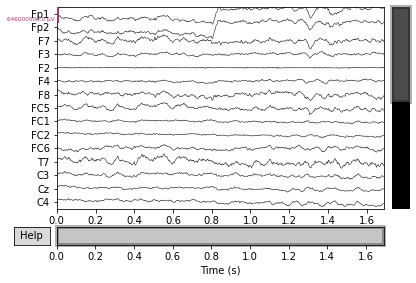

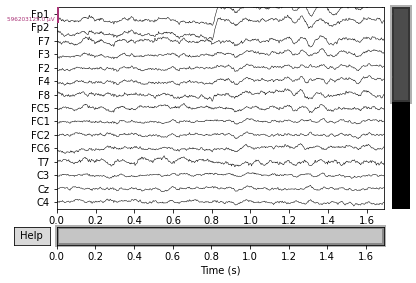

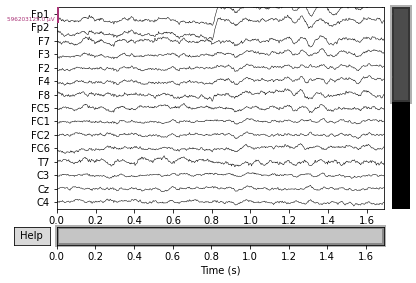

In [59]:
# using mne to find average
# eeg_close[2][0] represents one trial
# eeg_close[2][0]
info = mne.create_info(ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'F2', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10'], sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(eeg_close[2][0], info)
ref = mne.set_eeg_reference(raw, ref_channels='average', copy=True, projection=False, ch_type='auto', forward=None, verbose=None)[0]
raw.plot(n_channels = 15, scalings = "auto")
ref.plot(n_channels = 15, scalings = "auto")




# Filtering

In [60]:
flt_rarray = ref.copy().filter( l_freq = 7.5, h_freq = 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



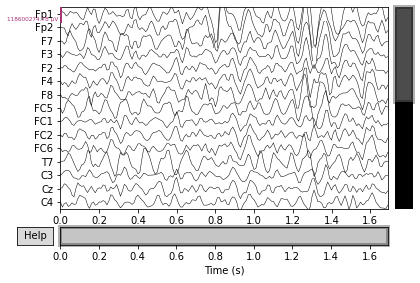

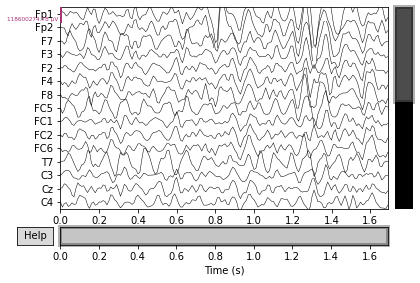

In [61]:
flt_rarray.plot(n_channels = 15, scalings = "auto")

In [62]:
series = [2, 3, 4, 5, 7, 8, 9]
eeg_open = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(eeg_grasp_open[s])
    eeg_open[series[i]] = new_list
#print(eeg_open.keys())
#print(eeg_open.values())

In [63]:
series = [2, 3, 4, 5, 7, 8, 9]
emg_close = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(emg_grasp_closed[s])
    emg_close[series[i]] = new_list
#print(emg_close.keys())
#print(emg_close.values())

In [64]:
series = [2, 3, 4, 5, 7, 8, 9]

emg_open = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(emg_grasp_open[s])
    emg_open[series[i]] = new_list
#print(emg_open.keys())
#print(emg_open.values())